Part 3. Are there any connections between the number of reviews and price?
This part, I will use some language analysing toolkits to analyse the reviews, and see are there any
relationships between reviews and prices.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
# nltk.download('vader_lexicon')

In [2]:
# load data
df_reviews = pd.read_csv("data/reviews.csv")
df_reviews = df_reviews.dropna()

In [3]:
# analyse the reviews, give out the scores to evaluate polarity of the comments
# using a build-in analyzer in the NLTK Python library.
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

df_reviews['polarity_value'] = "Default"
df_reviews['neg'] = 0.0
df_reviews['pos'] = 0.0
df_reviews['neu'] = 0.0
df_reviews['compound'] = 0.0
for index,row in df_reviews.iterrows():
    ss = sid.polarity_scores(row['comments'])
    df_reviews.at[index,'polarity_value'] = ss
    df_reviews.at[index,'neg'] = ss['neg']
    df_reviews.at[index,'pos'] = ss['pos']
    df_reviews.at[index,'neu']= ss['neu']
    df_reviews.at[index,'compound'] = ss['compound']
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,polarity_value,neg,pos,neu,compound
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,"{'neg': 0.0, 'neu': 0.462, 'pos': 0.538, 'comp...",0.000,0.538,0.462,0.7901
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,"{'neg': 0.0, 'neu': 0.609, 'pos': 0.391, 'comp...",0.000,0.391,0.609,0.9872
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...","{'neg': 0.043, 'neu': 0.772, 'pos': 0.185, 'co...",0.043,0.185,0.772,0.8718
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,"{'neg': 0.035, 'neu': 0.765, 'pos': 0.2, 'comp...",0.035,0.200,0.765,0.8313
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,"{'neg': 0.0, 'neu': 0.655, 'pos': 0.345, 'comp...",0.000,0.345,0.655,0.9783


In [4]:
# save the data
df_reviews.to_csv('data/polarity_reviews')

In [5]:
# remove the comments that are not in English, as the build-in NLTK analyzer only support English
from langdetect import detect

def detect_lang(sente):
    sente=str(sente)
    try:
        return detect(sente)
    except:
        return "None"
    
for index, row in df_reviews.iterrows():
    lang = detect_lang(row['comments'])
    df_reviews.at[index,'language'] = lang
    
df_reviewsEng = df_reviews[df_reviews.language=='en']

In [6]:
# polarity score for positivity
polarDF = df_reviewsEng[['pos']]
polarDF = polarDF.groupby(pd.cut(polarDF['pos'], np.arange(0, 1.1, 0.1))).count()
polarDF = polarDF.rename(columns={'pos':'Count'})
polarDF = polarDF.reset_index()
polarDF = polarDF.rename(columns={'pos':'range_i'})
for i,r in polarDF.iterrows():
    polarDF.at[i,'Range'] = float(str(r['range_i'])[1:4].replace(',',''))
    polarDF.at[i,'Sentiment'] = 'positive'
del polarDF['range_i']

In [7]:
# polarity score for negativity
polarDF_neg = df_reviewsEng[['neg']]
polarDF_neg = polarDF_neg.groupby(pd.cut(polarDF_neg['neg'], np.arange(0, 1.1, 0.1))).count()
polarDF_neg = polarDF_neg.rename(columns={'neg':'Count'})
polarDF_neg = polarDF_neg.reset_index()
polarDF_neg = polarDF_neg.rename(columns={'neg':'range_i'})
for i,r in polarDF_neg.iterrows():
    polarDF_neg.at[i,'Range'] = float(str(r['range_i'])[1:4].replace(',', ''))
    polarDF_neg.at[i,'Sentiment'] = 'negative'
del polarDF_neg['range_i']
for i,r in polarDF_neg.iterrows():
    polarDF = polarDF.append(pd.Series([r[0],r[1],r[2]],index=['Count','Range','Sentiment']),ignore_index=True)

In [8]:
# polarity score for neutrality
polarDF_neut = df_reviewsEng[['neu']]
polarDF_neut = polarDF_neut.groupby(pd.cut(polarDF_neut["neu"], np.arange(0, 1.0, 0.1))).count()
polarDF_neut = polarDF_neut.rename(columns={'neu':'Count'})
polarDF_neut = polarDF_neut.reset_index()
polarDF_neut = polarDF_neut.rename(columns={'neu':'range_i'})
for i,r in polarDF_neut.iterrows():
    polarDF_neut.at[i,'Range'] = float(str(r['range_i'])[1:4].replace(',',''))
    polarDF_neut.at[i,'Sentiment'] = 'neutral' 
del polarDF_neut['range_i']
for i,r in polarDF_neut.iterrows():
    polarDF = polarDF.append(pd.Series([r[0],r[1],r[2]],index=['Count','Range','Sentiment']),ignore_index=True)

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

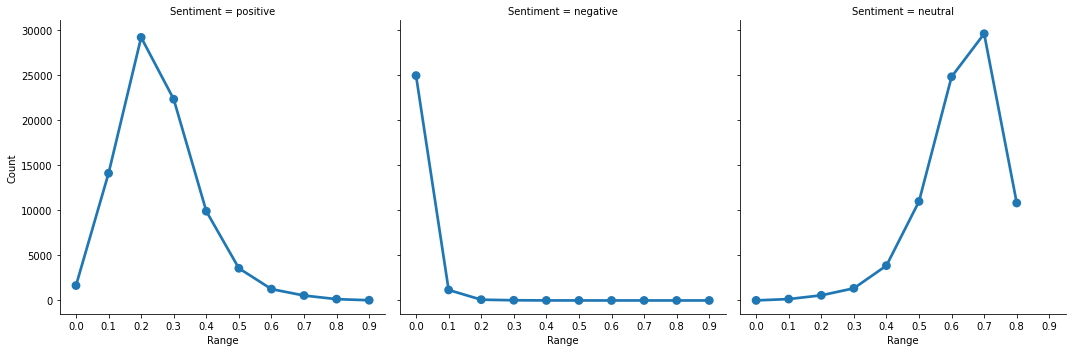

In [9]:
# Plotting the number of comments against the polarity range
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sns.catplot(data=polarDF, x="Range", y="Count", col="Sentiment", kind='point') 

As the figure shows, most comments have 0 negative polarity. In other words, most comments are either positive or neutral.

Next, interpreting the relation between number of reviews and prices.

<AxesSubplot:title={'center':'Reviews based on Price'}, xlabel='price'>

Text(0.5, 0, 'price')

Text(0, 0.5, 'Number of reviews')

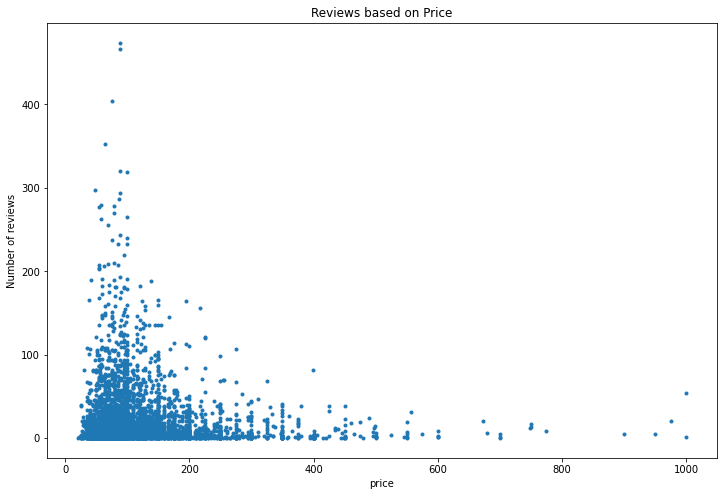

In [10]:
inputDF = pd.read_csv('data/listings.csv')
inputDF=inputDF[['number_of_reviews','price','review_scores_rating']]

# replacing NaN values with 0
inputDF.fillna(0, inplace=True)

#Extracting prices from the table
price = inputDF['price']
prices=[]

#clean the data to make it float
for p in price:
    p=float(p[1:].replace(',',''))
    prices.append(p)

#replace the price column with the new column
inputDF['price']=prices

price_review = inputDF[['number_of_reviews', 'price']].sort_values(by = 'price')

price_review.plot(x = 'price', 
                  y = 'number_of_reviews', 
                  style = '.',
                  figsize =(12,8),
                  legend = False,
                  title = 'Reviews based on Price')

plt.xlabel("price")
plt.ylabel("Number of reviews")

This figure shows that the listings whose price range around 100 to 300 get the most comments.
And the number decreases fast while the price get increased. So that no relation between the number of comments and prices is found.